In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time

import pandas

import pickle as pk

from keras.wrappers.scikit_learn import KerasClassifier

seed = 7

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(seed)

# Data Augmentation

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [4]:
img = load_img('/data/oxford102/jpg/image_00001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='flower', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)


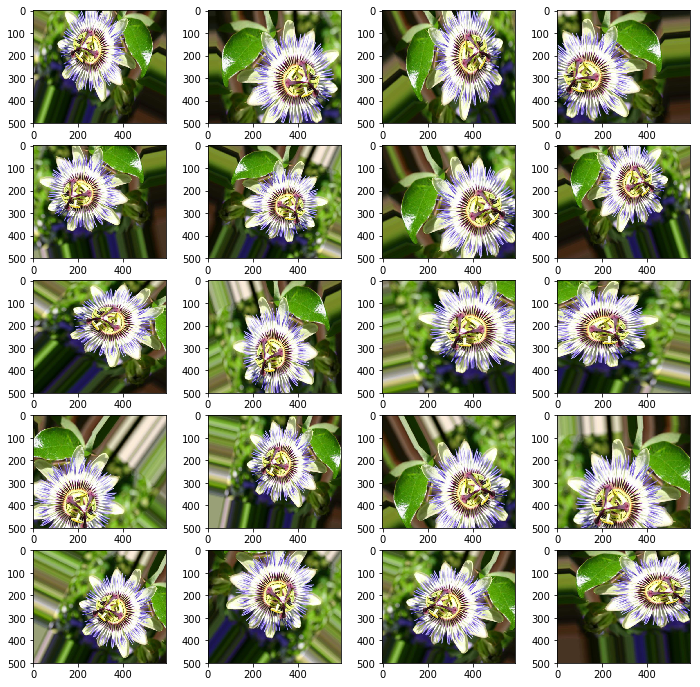

In [5]:
category = "/data/preview/"
imgs = np.random.choice(os.listdir(category), size=20, replace=False)
#os.listdir(category)

w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    img=mpimg.imread(category + imgs[i-1])
    print(img.shape)
    imgplot = plt.imshow(img)
plt.show()

# Train small convnet

In [157]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [158]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation="softmax"))
#model.add(Activation('sigmoid'))


# #Adding custom Layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# #x = Dense(1024, activation="relu")(x)
# predictions = Dense(nr_categories, activation="softmax")(x)



model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              #optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

#model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_65 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_66 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 60, 60, 64)        18496     
__________

In [224]:
def get_model(optimizer=optimizers.SGD, verbose=False, n_categories=2, image_size=(150,150)):

    img_with, image_height = image_size
    model = None
    model = Sequential()

    #conv_layer1
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_with, image_height, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    

    if n_categories == 2:
        model.add(Activation('sigmoid'))
    else:
        model.add(Dense(102, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    if verbose:
        model.summary()

    return model

In [161]:
def get_image_generator(image_augmentation=False, validation_split=0.2):
    if not image_augmentation:
        return ImageDataGenerator(rescale=1./255,
                                  validation_split=validation_split)

    return ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split)

In [162]:
train_val_datagen_no_aug = get_image_generator()

In [163]:
train_val_datagen = get_image_generator(True)

In [164]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [165]:
data_dir = '/data/oxford102/train'
img_width, img_height = 256, 256
batch_size = 32
epochs = 100

In [166]:
train_generator = train_datagen.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

Found 4604 images belonging to 102 classes.


In [167]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

Found 1094 images belonging to 102 classes.


In [223]:
def setup_model(params):
    data_dir = '/data/oxford102/train'
    img_width, img_height = params.get('image_size')
    batch_size =  params.get("batch_size")

    if params.get("optimizer") == "rmsprop":
        opt = "rmsprop"
    elif params.get("optimizer") == "sgd":
        opt = optimizers.SGD(lr=0.0001, momentum=0.9)
    elif params.get("optimizer") == "adam":
        opt = optimizers.Adam()    
        
    if not params.get("image_aug"):
        train_val_datagen_no_aug = get_image_generator()
    else: 
        train_val_datagen_no_aug = get_image_generator(True)
    model = None
    model = get_model(optimizer=opt, image_size=params.get('image_size'), n_categories=102, verbose=True)
       
    return model
    

In [216]:
optimizers.Adam


keras.optimizers.Adam

In [190]:
def get_generators(params):
    img_width, img_height = params.get('image_size')
    batch_size =  params.get("batch_size")
    
    train_generator = train_val_datagen_no_aug.flow_from_directory(
        data_dir,  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 250x250
        batch_size=batch_size,
        class_mode='categorical',
        subset = "training")    
        
    validation_generator = train_datagen.flow_from_directory(
        data_dir,  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 250x250
        batch_size=batch_size,
        class_mode='categorical',
        subset="validation")
    
    return train_generator, validation_generator

In [220]:
import os

def run_training(model, train_gen, val_gen, params, num_train_img, num_val_img):
    np.random.seed(seed)
    log_time = time()
    params['log_time'] = log_time
    
    base = '/data/oxford102/experiments'
    path = os.path.join(base, str(log_time))
    checkpoint = ModelCheckpoint(os.path.join(path, "small_convnet_{}.h5".format(log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
    tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
    csv_logger = CSVLogger(os.path.join(path, "small_convnet_{}.csv".format(log_time)), append=True, separator=';')

    try:
        if not os.path.exists(path):
            os.makedirs(path)
        history_callback = model.fit_generator(
                train_generator,
                steps_per_epoch=num_train_img // batch_size,
                epochs=params.get("epochs"),
                validation_data=validation_generator,
                validation_steps=num_val_img // batch_size,
                callbacks = [checkpoint, early, tensorboard, csv_logger])
    except Exception as e:
        raise(e)
    finally:
        pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
        model.save_weights(os.path.join(path, 'model_weights_final_{}.h5'.format(log_time)))  # always save your weights after training or during training
        print(params)
        params
        #with open("experiments")
        # Saving the Loss:
        # with the csvlogger callback
        # see the training callba balls

        # with pandas
        #pandas.DataFrame(history_callback.history).to_csv("history_small_convnet_rmsprop_50_100.csv")

        #with numpy
        # loss_history = history_callback.history["loss"]
        # numpy_loss_history = np.array(loss_history)
        # np.savetxt("loss_history_small_convnet_rmsprop_50_100.txt", numpy_loss_history, delimiter=",")


In [222]:
def run(params):
    model = None
    import gc
    gc.collect()
    model = setup_model(params)
    train_generator, validation_generator = get_generators(params)
    run_training(model, train_generator, validation_generator, params, 4604, 1094)

In [180]:
training_params = {
    1: {'log_time': None, 'optimizer': optimizers.rmsprop, 'image_augmentation': True, "tensorboard_id":1},
    2: {'log_time': None, 'optimizer': optimizers.rmsprop, 'image_augmentation': False, "tensorboard_id":2},
    2: {'log_time': None, 'optimizer': optimizers.SGD(lr=0.0001, momentum=0.9), 'image_augmentation': True, "tensorboard_id":3},
    2: {'log_time': None, 'optimizer': optimizers.SGD(lr=0.0001, momentum=0.9), 'image_augmentation': False, "tensorboard_id":4},
}

In [181]:
params = {'image_aug': False,
         'optimizer': 'rmsprop', 
         'batch_size': 16,
         'epochs': 100,
         'image_size': (256, 256),
         'log_time': None}

In [191]:
model = setup_model(params)
train_generator, validation_generator = get_generators(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_86 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_87 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 60, 60, 64)        18496     
__________

In [183]:
run_training(model, train_generator, validation_generator, params, 4604, 1094)

Epoch 1/100
143/143 [==============================] - 45s 316ms/step - loss: 4.5521 - acc: 0.0449 - val_loss: 4.4368 - val_acc: 0.0460

Epoch 00001: val_acc improved from -inf to 0.04596, saving model to /data/oxford102/small_convnet_rmsprop_1541280636.0738575.h5
Epoch 2/100
143/143 [==============================] - 41s 289ms/step - loss: 4.0448 - acc: 0.0935 - val_loss: 3.8645 - val_acc: 0.1085

Epoch 00002: val_acc improved from 0.04596 to 0.10846, saving model to /data/oxford102/small_convnet_rmsprop_1541280636.0738575.h5
Epoch 3/100
143/143 [==============================] - 41s 287ms/step - loss: 3.6043 - acc: 0.1399 - val_loss: 3.6727 - val_acc: 0.1268

Epoch 00003: val_acc improved from 0.10846 to 0.12684, saving model to /data/oxford102/small_convnet_rmsprop_1541280636.0738575.h5
Epoch 4/100
143/143 [==============================] - 38s 268ms/step - loss: 3.3926 - acc: 0.1846 - val_loss: 3.5478 - val_acc: 0.1305

Epoch 00004: val_acc improved from 0.12684 to 0.13051, saving 

In [200]:
params['log_time'] = 1541280636.0738575

In [201]:
params

{'image_aug': False,
 'optimizer': 'sgd',
 'batch_size': 16,
 'epochs': 100,
 'image_size': (256, 256),
 'log_time': 1541280636.0738575}

In [194]:
params = {'image_aug': False,
         'optimizer': 'sgd', 
         'batch_size': 16,
         'epochs': 100,
         'image_size': (256, 256),
         'log_time': None}

In [195]:
model = setup_model(params)
train_generator, validation_generator = get_generators(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_90 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_91 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 60, 60, 64)        18496     
__________

In [196]:
run_training(model, train_generator, validation_generator, params, 4604, 1094)

Epoch 1/100
143/143 [==============================] - 41s 286ms/step - loss: 4.6155 - acc: 0.0105 - val_loss: 4.5992 - val_acc: 0.0147

Epoch 00001: val_acc improved from -inf to 0.01471, saving model to /data/small_convnet_rmsprop_1541282206.2238407.h5
Epoch 2/100
143/143 [==============================] - 38s 267ms/step - loss: 4.5883 - acc: 0.0188 - val_loss: 4.5669 - val_acc: 0.0147

Epoch 00002: val_acc did not improve from 0.01471
Epoch 3/100
143/143 [==============================] - 40s 281ms/step - loss: 4.5671 - acc: 0.0227 - val_loss: 4.5429 - val_acc: 0.0221

Epoch 00003: val_acc improved from 0.01471 to 0.02206, saving model to /data/small_convnet_rmsprop_1541282206.2238407.h5
Epoch 4/100
143/143 [==============================] - 38s 267ms/step - loss: 4.5467 - acc: 0.0235 - val_loss: 4.5200 - val_acc: 0.0276

Epoch 00004: val_acc improved from 0.02206 to 0.02757, saving model to /data/small_convnet_rmsprop_1541282206.2238407.h5
Epoch 5/100
143/143 [=====================

In [199]:
params

{'image_aug': False,
 'optimizer': 'sgd',
 'batch_size': 16,
 'epochs': 100,
 'image_size': (256, 256),
 'log_time': 1541282206.2238407}

In [207]:
# params = {'image_aug': False,
#          'optimizer': 'sgd', 
#          'batch_size': 16,
#          'epochs': 100,
#          'image_size': (256, 256),
#          'log_time': None}

In [211]:
params['optimizer'] = "adam"

In [221]:
run(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_106 (Activation)  (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_107 (Activation)  (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 60, 60, 64)        18496     
__________

In [225]:
params = {'image_aug': False,
         'optimizer': 'sgd', 
         'batch_size': 32,
         'epochs': 100,
         'image_size': (256, 256),
         'log_time': None}

In [226]:
run(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_110 (Activation)  (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_111 (Activation)  (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 60, 60, 64)        18496     
__________

Epoch 26/100
143/143 [==============================] - 38s 267ms/step - loss: 3.9269 - acc: 0.1171 - val_loss: 4.0244 - val_acc: 0.0993

Epoch 00026: val_acc did not improve from 0.11029
Epoch 27/100
143/143 [==============================] - 38s 265ms/step - loss: 3.8310 - acc: 0.1307 - val_loss: 4.0434 - val_acc: 0.0864

Epoch 00027: val_acc did not improve from 0.11029
Epoch 28/100
143/143 [==============================] - 38s 263ms/step - loss: 3.8433 - acc: 0.1324 - val_loss: 4.0048 - val_acc: 0.1011

Epoch 00028: val_acc did not improve from 0.11029
Epoch 29/100
143/143 [==============================] - 38s 265ms/step - loss: 3.7637 - acc: 0.1364 - val_loss: 3.9287 - val_acc: 0.0938

Epoch 00029: val_acc did not improve from 0.11029
Epoch 30/100
143/143 [==============================] - 39s 270ms/step - loss: 3.7487 - acc: 0.1458 - val_loss: 3.9656 - val_acc: 0.1121

Epoch 00030: val_acc improved from 0.11029 to 0.11213, saving model to /data/oxford102/experiments/1541285373.

In [ ]:

#model.save_weights('first_try.h5')  # always save your weights after training or during training

In [40]:
# Saving the Loss:
# with the csvlogger callback
# see the training callba balls

# with pandas
#pandas.DataFrame(history_callback.history).to_csv("history_small_convnet_rmsprop_50_100.csv")

#with numpy
# loss_history = history_callback.history["loss"]
# numpy_loss_history = np.array(loss_history)
# np.savetxt("loss_history_small_convnet_rmsprop_50_100.txt", numpy_loss_history, delimiter=",")

In [38]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_50_100.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = CSVLogger('small_convnet_1.csv', append=True, separator=';')


In [39]:
history_callback = model.fit_generator(
        train_generator,
        steps_per_epoch=4604 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1094 // batch_size,
        callbacks = [checkpoint, early, tensorboard, csv_logger])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
143/143 [==============================] - 138s 962ms/step - loss: 2.1866 - acc: 0.4259 - val_loss: 2.2184 - val_acc: 0.4449

Epoch 00001: val_acc improved from -inf to 0.44485, saving model to /data/oxford102/small_convnet_rmsprop_50_100.h5
Epoch 2/50
143/143 [==============================] - 136s 952ms/step - loss: 2.1981 - acc: 0.4379 - val_loss: 2.4922 - val_acc: 0.3925

Epoch 00002: val_acc did not improve from 0.44485
Epoch 3/50
143/143 [==============================] - 136s 948ms/step - loss: 2.1921 - acc: 0.4314 - val_loss: 2.2402 - val_acc: 0.4320

Epoch 00003: val_acc did not improve from 0.44485
Epoch 4/50
143/143 [==============================] - 135s 947ms/step - loss: 2.1730 - acc: 0.4242 - val_loss: 2.5977 - val_acc: 0.3869

Epoch 00004: val_acc did not improve from 0.44485
Epoch 5/50
143/143 [==============================] - 135s 943ms/step - loss: 2.1493 - acc: 0.4379 - val_loss: 2.2394 - val_acc: 0.4347

Epoch 00005: val_acc did not improve from 0.44485

In [ ]:
model.predict_classes()

In [ ]:
# no image aug

In [44]:
train_generator = train_datagen_no_aug.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

validation_generator = train_datagen_no_aug.flow_from_directory(
    data_dir,  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to 250x250
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


In [ ]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_50_100_nodaug.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = CSVLogger('small_convnet_1.csv', append=True, separator=';')


In [ ]:
history_callback = model.fit_generator(
        train_generator,
        steps_per_epoch=4604 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1094 // batch_size,
        callbacks = [checkpoint, early, tensorboard, csv_logger])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

In [55]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [56]:
def preprocess_img(img):

    image=mpimg.imread(img)
    imgplot = plt.imshow(image)

    image = load_img(img, target_size=(256, 256))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # do the same preprocessing as the vgg did
    image = preprocess_input(image)
    return image

In [57]:
def predict(img_arr):
    # predict the probability across all output classes
    yhat = model.predict(img_arr)
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    print('%s (%.2f%%)' % (label[1], label[2]*100))

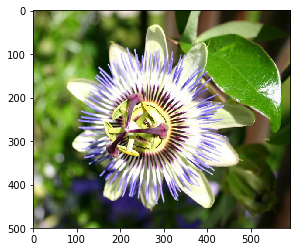

In [59]:
img = '/data/oxford102/jpg/image_00001.jpg'
image_array = preprocess_img(img)
#predict(image_array)

In [34]:
plot_model(model, to_file='baseline_CNN.png')

In [80]:
pred = model.predict_proba(image_array)

In [61]:
class_labels = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

In [62]:
_class_labels = np.array(class_labels)

In [67]:
_class_labels

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

In [79]:
for i,x in enumerate(pred[0]):
    if x == 1.0:
        print(_class_labels[i])

oxeye daisy


In [83]:
probabilities = model.predict_generator(validation_generator)

In [97]:
probabilities[1]> 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

# optimizer=SGD

In [15]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_sgd.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)

In [16]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 114s 320ms/step - loss: 4.6108 - acc: 0.0170 - val_loss: 4.5910 - val_acc: 0.0189

Epoch 00001: val_acc improved from -inf to 0.01891, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 2/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5813 - acc: 0.0242 - val_loss: 4.5587 - val_acc: 0.0362

Epoch 00002: val_acc improved from 0.01891 to 0.03618, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 3/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5638 - acc: 0.0251 - val_loss: 4.5389 - val_acc: 0.0354

Epoch 00003: val_acc did not improve from 0.03618
Epoch 4/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5526 - acc: 0.0270 - val_loss: 4.5243 - val_acc: 0.0329

Epoch 00004: val_acc did not improve from 0.03618
Epoch 5/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5374 - acc: 0.0297 - val_loss: 4.5045 - val_acc: 0.0391

Ep

356/356 [==============================] - 113s 319ms/step - loss: 3.2517 - acc: 0.1984 - val_loss: 3.0567 - val_acc: 0.2562

Epoch 00036: val_acc improved from 0.25452 to 0.25617, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 37/50
356/356 [==============================] - 112s 315ms/step - loss: 3.1939 - acc: 0.2214 - val_loss: 3.0105 - val_acc: 0.2599

Epoch 00037: val_acc improved from 0.25617 to 0.25987, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 38/50
356/356 [==============================] - 112s 313ms/step - loss: 3.1559 - acc: 0.2221 - val_loss: 2.9975 - val_acc: 0.2627

Epoch 00038: val_acc improved from 0.25987 to 0.26275, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 39/50
356/356 [==============================] - 111s 311ms/step - loss: 3.1410 - acc: 0.2323 - val_loss: 2.9733 - val_acc: 0.2854

Epoch 00039: val_acc improved from 0.26275 to 0.28536, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 40/50
356/356 [=======

# With Data augmentation

In [23]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_more_augmentation.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 115s 323ms/step - loss: 4.2427 - acc: 0.0620 - val_loss: 3.7434 - val_acc: 0.1172

Epoch 00001: val_acc improved from -inf to 0.11719, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 2/50
356/356 [==============================] - 115s 324ms/step - loss: 3.6455 - acc: 0.1178 - val_loss: 3.2986 - val_acc: 0.1945

Epoch 00002: val_acc improved from 0.11719 to 0.19449, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 3/50
356/356 [==============================] - 115s 322ms/step - loss: 3.3467 - acc: 0.1733 - val_loss: 3.0784 - val_acc: 0.2484

Epoch 00003: val_acc improved from 0.19449 to 0.24836, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 4/50
356/356 [==============================] - 115s 322ms/step - loss: 3.1507 - acc: 0.2242 - val_loss: 3.4569 - val_acc: 0.2270

Epoch 00004: val_acc did not improve from 0.24836
Epoch 5/50
356/

In [ ]:
# batch_size = 16

# # this is the augmentation configuration we will use for training
# train_datagen_no_aug = ImageDataGenerator(
#         rescale=1./255,
#         validation_split=0.2
# )
# train_datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest',
#         validation_split=0.2)

# # this is the augmentation configuration we will use for testing:
# # only rescaling
# test_datagen = ImageDataGenerator(rescale=1./255)

# # this is a generator that will read pictures found in
# # subfolers of 'data/train', and indefinitely generate
# # batches of augmented image data
# # train_generator = train_datagen.flow_from_directory(
# #         '/data/oxford102/train',  # this is the target directory
# #         target_size=(150, 150),  # all images will be resized to 150x150
# #         batch_size=batch_size,
# #         class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# # # this is a similar generator, for validation data
# # validation_generator = test_datagen.flow_from_directory(
# #         '/data/oxford102/val',
# #         target_size=(150, 150),
# #         batch_size=batch_size,
# #         class_mode='categorical')

# data_dir = '/data/oxford102/train'
# img_width, img_height = 256, 256
# batch_size = 32
# epochs = 100
    
# train_generator = train_datagen.flow_from_directory(
#     data_dir,  # this is the target directory
#     target_size=(img_width, img_height),  # all images will be resized to 250x250
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset = "training")

# validation_generator = train_datagen.flow_from_directory(
#     data_dir,  # this is the target directory
#     target_size=(img_width, img_height),  # all images will be resized to 250x250
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset="validation")